In [2]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
C:\Users\spice\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# Load csv file of bitcoin data
csv_path = Path("BTC2016.csv")
btc=pd.read_csv(csv_path)
btc.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2016-07-28,655.42700,656.91599,658.63100,654.16099
1,BTC,2016-07-29,656.68100,655.42700,658.25299,654.38500
2,BTC,2016-07-30,635.58800,656.68100,658.28300,634.84899
3,BTC,2016-07-31,621.37299,635.58800,639.38199,616.04800
4,BTC,2016-08-01,601.22700,621.37299,627.06800,600.74100


In [4]:
btc = btc.drop(columns="Currency")

In [5]:
btc['Date']=btc['Date'].astype('datetime64[ns]')

In [6]:
# Set the `Date` column as the index
btc = btc.set_index("Date", drop=True)

In [7]:
btc.head()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,
2016-07-28,655.42700,656.91599,658.63100,654.16099
2016-07-29,656.68100,655.42700,658.25299,654.38500
2016-07-30,635.58800,656.68100,658.28300,634.84899
2016-07-31,621.37299,635.58800,639.38199,616.04800
2016-08-01,601.22700,621.37299,627.06800,600.74100


In [8]:
# Rename the columns
btc.columns = ['Close', 'Open', 'High', 'Low']
btc.head()

,Close,Open,High,Low
Date,,,,
2016-07-28,655.42700,656.91599,658.63100,654.16099
2016-07-29,656.68100,655.42700,658.25299,654.38500
2016-07-30,635.58800,656.68100,658.28300,634.84899
2016-07-31,621.37299,635.58800,639.38199,616.04800
2016-08-01,601.22700,621.37299,627.06800,600.74100


In [20]:
## Initialize the short and long windows

short_window = 50
long_window = 100

In [32]:
## Initialize the signals DataFrame with the signal column

signals = pd.DataFrame(index=btc.index)
signals['close'] = btc['Close']
signals['signal'] = 0.0

In [33]:
## Create short simple moving average over the short window

signals['SMA50'] = btc['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

In [34]:
## Create long simple moving average over the long window

signals['SMA100'] = btc['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

In [35]:
## Create signals

signals['signal'][short_window:] = np.where(signals['SMA50'][short_window:] > signals['SMA100'][short_window:],1.0,0.0)

In [36]:
## Generate trading orders

signals['entry/exit'] = signals['signal'].diff()

In [38]:
signals.head()

,close,signal,SMA50,SMA100,entry/exit
Date,,,,,
2016-07-28,655.42700,0.0,655.427000,655.427000,NaN
2016-07-29,656.68100,0.0,656.054000,656.054000,0.0
2016-07-30,635.58800,0.0,649.232000,649.232000,0.0
2016-07-31,621.37299,0.0,642.267248,642.267248,0.0
2016-08-01,601.22700,0.0,634.059198,634.059198,0.0


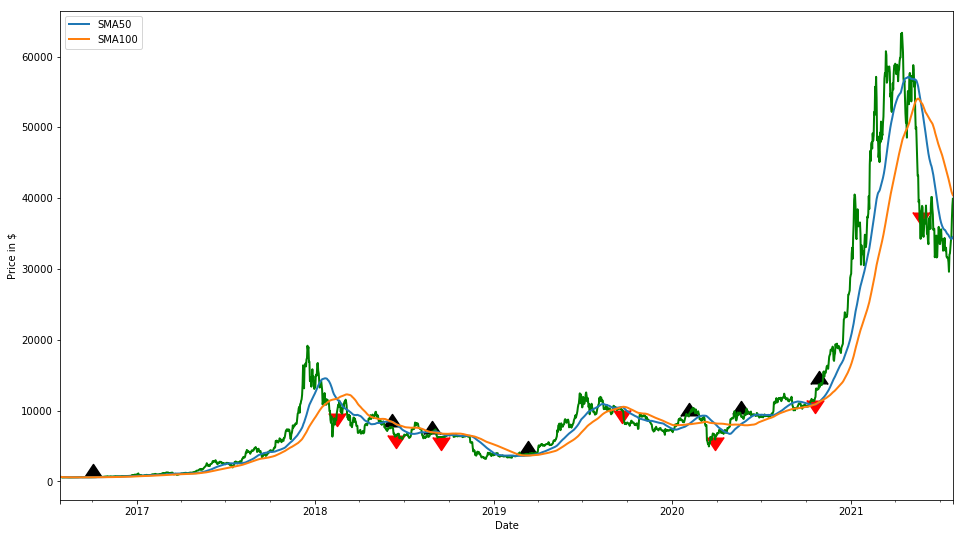

In [41]:
## Initialize the plot figure

fig = plt.figure(figsize=(16,9))

## Add a subplot and label for y-axis

ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the closing price

btc['Close'].plot(ax=ax1, color='g', lw=2.)

## Plot the short and long moving averages

signals[['SMA50','SMA100']].plot(ax=ax1, lw=2.)

## Plot the buy signals

#signals.short_mavg[signals.positions == 1.0].scatter(ax=ax1, color='g')
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index, 
            signals.close[signals['entry/exit'] == 1.0],
            marker=10, s=300, color='black')

## Plot the sell signals
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.close[signals['entry/exit'] == -1.0],
            marker=11, s=300, color='r')


## Show the plot

plt.show()

In [73]:
signals.SMA50[signals['entry/exit'] == 1.0].shape

(7,)

In [43]:
signals.loc[signals['entry/exit'] == 1.0].index

DatetimeIndex(['2016-10-04', '2018-06-07', '2018-08-27', '2019-03-13',
               '2020-02-04', '2020-05-20', '2020-10-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

### Backtest the Trading Strategy

In [54]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals['Position'] = share_size * signals['signal']

# Find the points in time where a 500 share position is bought or sold
signals['Entry/Exit Position'] = signals['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals['Portfolio Holdings'] = signals['close'] * signals['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals['Portfolio Cash'] = initial_capital - (signals['close'] * signals['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals['PortfolioTotal'] = signals['Portfolio Cash'] + signals['Portfolio Holdings']

# Calculate the portfolio daily returns
signals['Portfolio Daily Returns'] = signals['PortfolioTotal'].pct_change()

# Calculate the cumulative returns
signals['Portfolio Cumulative Returns'] = (1 + signals['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals.head()

,close,signal,SMA50,SMA100,entry/exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns,PortfolioTotal
Date,,,,,,,,,,,,,
2016-07-28,655.42700,0.0,655.427000,655.427000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-29,656.68100,0.0,656.054000,656.054000,0.0,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN,100000.0
2016-07-30,635.58800,0.0,649.232000,649.232000,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0,100000.0
2016-07-31,621.37299,0.0,642.267248,642.267248,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0,100000.0
2016-08-01,601.22700,0.0,634.059198,634.059198,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0,100000.0


### Plot Entry/Exit Points of Trading Strategy vs. Backtest Results

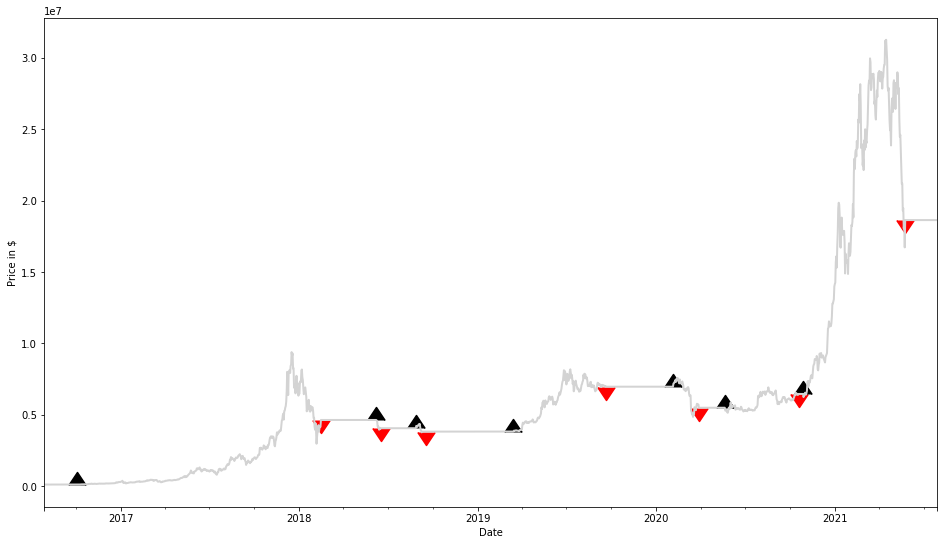

In [57]:
# Visualize exit position relative to total portfolio value
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the total portoflio value for the investment
#btc['Close'].plot(ax=ax1, color='g', lw=2.)
signals['PortfolioTotal'].plot(ax=ax1, color='lightgrey', lw=2.)

# Plot exit position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == -1.0],
            marker=11, s=300, color='r')

# Plot entry position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == 1.0],
            marker=10, s=300, color='black')

In [48]:
signals[signals['entry/exit'] == 1.0]['Portfolio Total']

Date
2016-10-04    1.000000e+05
2018-06-07    4.625581e+06
2018-08-27    4.047888e+06
2019-03-13    3.810278e+06
2020-02-04    6.956309e+06
2020-05-20    5.482106e+06
2020-10-27    6.447164e+06
Name: Portfolio Total, dtype: float64

### portofolio evaluation metrics

In [58]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [59]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = signals['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    signals['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals['Portfolio Daily Returns'].mean() * 252) / (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = signals[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,0.906849
Cumulative Returns,185.294
Annual Volatility,0.604285
Sharpe Ratio,1.5007
Sortino Ratio,2.28511


### Trade Evaluation Metrics

In [67]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Cryptocurrency', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [70]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in signals.iterrows():
    if row['entry/exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['entry/exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Cryptocurrency': 'BTC',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,BTC,2016-10-04,2018-02-14,500.0,608.125000,9659.287500,3.040625e+05,4.829644e+06,-4.525581e+06
1,BTC,2018-06-07,2018-06-16,500.0,7684.930000,6529.544015,3.842465e+06,3.264772e+06,5.776930e+05
2,BTC,2018-08-27,2018-09-16,500.0,6756.628926,6281.409356,3.378314e+06,3.140705e+06,2.376098e+05
3,BTC,2019-03-13,2019-09-20,500.0,3846.274442,10138.335205,1.923137e+06,5.069168e+06,-3.146030e+06
4,BTC,2020-02-04,2020-03-28,500.0,9177.894637,6229.488343,4.588947e+06,3.114744e+06,1.474203e+06
5,BTC,2020-05-20,2020-10-18,500.0,9540.886567,11471.002548,4.770443e+06,5.735501e+06,-9.650580e+05
6,BTC,2020-10-27,2021-05-24,500.0,13721.282225,38085.789361,6.860641e+06,1.904289e+07,-1.218225e+07
7,BTC,2016-10-04,2018-02-14,500.0,608.125000,9659.287500,3.040625e+05,4.829644e+06,4.525581e+06
8,BTC,2018-06-07,2018-06-16,500.0,7684.930000,6529.544015,3.842465e+06,3.264772e+06,-5.776930e+05
9,BTC,2018-08-27,2018-09-16,500.0,6756.628926,6281.409356,3.378314e+06,3.140705e+06,-2.376098e+05
